In [ ]:
import ee
ee.Authenticate()
project_id = 'stellar-day-463918-k5'
ee.Initialize(project=project_id)


In [ ]:
import geemap


In [ ]:

#Define AOI
Map = geemap.Map(center=[37.0, -120.0], zoom=7)
Map.add_basemap('SATELLITE')
Map

Map(center=[37.0, -120.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [ ]:
aoi = Map.user_roi

if aoi is None:
    print("Please draw a polygon first.")
else:
    print("AOI defined successfully.")

AOI defined successfully.


In [ ]:
#Load Sentinel-2 image from EE

s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterBounds(aoi) \
    .filterDate('2022-06-01', '2022-09-01') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
    .median() \
    .clip(aoi)


In [ ]:
#Add NDVI and NBR indices
def add_indices(img):
    ndvi = img.normalizedDifference(['B8', 'B4']).rename('NDVI')
    nbr = img.normalizedDifference(['B8', 'B12']).rename('NBR')
    return img.addBands([ndvi, nbr])

image = add_indices(s2).select(['B2', 'B3', 'B4', 'B8', 'B11', 'NDVI', 'NBR'])

In [ ]:
#Use ESA worldcover as Trainiing Labels
labels = ee.Image('ESA/WorldCover/v100/2020').clip(aoi)

# Combine image bands and label band
stacked = image.addBands(labels.rename('label'))

In [ ]:
#visualise labels
# Optional: Visualize the label band using geemap
Map = geemap.Map()
Map.centerObject(aoi, 9)

# Define ESA WorldCover 2020 legend
legend_dict = {
    'Tree cover': '#006400',                 # Class 10
    'Shrubland': '#ffbb22',                  # Class 20
    'Grassland': '#ffff4c',                  # Class 30
    'Cropland': '#f096ff',                   # Class 40
    'Built-up': '#fa0000',                   # Class 50
    'Bare / sparse vegetation': '#b4b4b4',   # Class 60
    'Snow and ice': '#f0f0f0',               # Class 70
    'Permanent water bodies': '#0064c8',     # Class 80
    'Herbaceous wetland': '#0096a0',         # Class 90
    'Mangroves': '#00cf75',                  # Class 95
    'Moss and lichen': '#fae6a0'             # Class 100
}


# Add original image (e.g., RGB) for reference
Map.addLayer(image, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Input Image')

# Add the label map
Map.addLayer(labels, {'min': 10, 'max': 100, 'palette': ['006400', 'ffbb22', 'ffff4c', 'f096ff', 'fa0000', 'b4b4b4', 'f0f0f0', '0064c8', '0096a0', '00cf75', 'fae6a0', '58481f', '0096ff', '9f6fff', 'b4b4b4']}, 'WorldCover 2020')

# Add legend
Map.add_legend(title='ESA WorldCover 2020', legend_dict=legend_dict)

# Show map
Map

Map(center=[39.99490410865819, -122.16110199999986], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
#Sample Data for Training
points = stacked.sample(
    region=aoi,
    scale=10,
    numPixels=5000,
    seed=42,
    geometries=True
)

In [ ]:
#Export sample as GeoJSON to use in Python
geemap.ee_export_vector(points, filename='training_data.geojson')


Generating URL ...
Please wait ...
Data downloaded to /content/training_data.geojson


In [ ]:
#Now, in python, train classifier
import geopandas as gpd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

gdf = gpd.read_file('training_data.geojson')

features = ['B2', 'B3', 'B4', 'B8', 'B11', 'NDVI', 'NBR']
X = gdf[features].values
y = gdf['label'].values

clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X, y)

RandomForestClassifier(random_state=0)

In [ ]:
#Export image from GEE to drive

# Cast all bands to float32
image = image.toFloat()

task = ee.batch.Export.image.toDrive(
    image=image,
    description='central_valley_export',
    folder='GEE_Exports',
    fileNamePrefix='central_valley',
    region=aoi.getInfo()['coordinates'],
    scale=10,
    maxPixels=1e13
)

task.start()

print('Export started. Check your Google Drive GEE_Exports folder.')

Export started. Check your Google Drive GEE_Exports folder.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
tif_path = '/content/drive/My Drive/GEE_Exports/central_valley.tif'

In [ ]:
!pip install rasterio

In [ ]:
#Read the image using rasterio
import rasterio

with rasterio.open(tif_path) as src:
    img = src.read()  # shape: (bands, height, width)
    profile = src.profile

In [ ]:
#Reshape and prepare features for prediction
import numpy as np

bands, height, width = img.shape
X_all = img.reshape(bands, -1).T  # reshape to (pixels, bands)

In [ ]:
#Predict Land cover with your trained classifier (clf)
y_pred = clf.predict(X_all)
classified = y_pred.reshape(height, width)

In [ ]:
#Save the classified map as a Geotiff
with rasterio.open('classified_map.tif', 'w', **profile) as dst:
    dst.write(classified.astype(rasterio.uint8), 1)

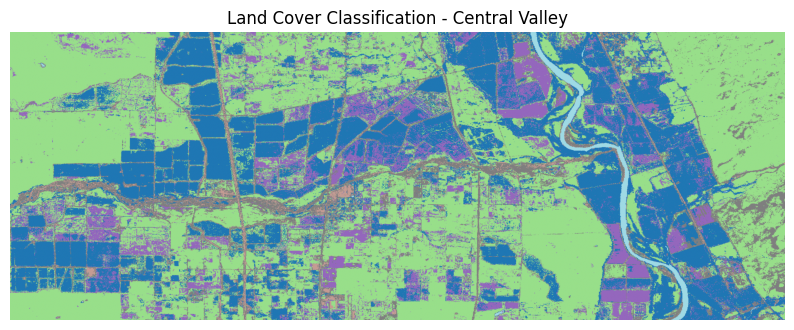

In [ ]:
#Visualize the classification
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(classified, cmap='tab20')
plt.title('Land Cover Classification - Central Valley')
plt.axis('off')
plt.show()

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score

# Assuming X, y are your full features and labels arrays

# Step 1: Split data into train and validation sets (70%-30%)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Step 2: Train classifier on training data
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Step 3: Predict on validation data
y_pred_val = clf.predict(X_val)

# Step 4: Print basic classification report and confusion matrix
print('Accuracy:', accuracy_score(y_val, y_pred_val))
cm = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix:\n', cm)
print('Classification Report:\n', classification_report(y_val, y_pred_val))

# Step 5: Calculate Overall Accuracy
overall_accuracy = np.trace(cm) / np.sum(cm)
print(f"Overall Accuracy: {overall_accuracy:.4f}")

# Step 6: Calculate Producer's Accuracy and User's Accuracy
sum_rows = np.sum(cm, axis=1)  # Actual class totals
sum_cols = np.sum(cm, axis=0)  # Predicted class totals

producer_accuracy = np.diag(cm) / sum_rows
user_accuracy = np.diag(cm) / sum_cols

for i, (pa, ua) in enumerate(zip(producer_accuracy, user_accuracy)):
    print(f"Class {i}: Producer's Accuracy = {pa:.4f}, User's Accuracy = {ua:.4f}")

# Step 7: Calculate Kappa coefficient
kappa = cohen_kappa_score(y_val, y_pred_val)
print(f"Kappa Coefficient: {kappa:.4f}")

Accuracy: 0.672
Confusion Matrix:
 [[269   0  38  34   1  18   0]
 [  0   0   1   0   0   0   0]
 [ 40   0 542  32   3  32   0]
 [ 45   0  93  96   1  14   0]
 [  0   0   5   1  17  19   0]
 [ 14   0  64  26  10  69   0]
 [  0   0   0   0   0   1  15]]
Classification Report:
               precision    recall  f1-score   support

          10       0.73      0.75      0.74       360
          20       0.00      0.00      0.00         1
          30       0.73      0.84      0.78       649
          40       0.51      0.39      0.44       249
          50       0.53      0.40      0.46        42
          60       0.45      0.38      0.41       183
          80       1.00      0.94      0.97        16

    accuracy                           0.67      1500
   macro avg       0.56      0.53      0.54      1500
weighted avg       0.66      0.67      0.66      1500

Overall Accuracy: 0.6720
Class 0: Producer's Accuracy = 0.7472, User's Accuracy = 0.7310
Class 1: Producer's Accuracy = 0.0000

In [ ]:
# Load ESA WorldCover and clip to ROI
esa = ee.Image('ESA/WorldCover/v100/2020').clip(aoi)
geemap.ee_export_image_to_drive(
    image=esa,
    description='esa_worldcover',
    folder='GEE_Exports',
    region=aoi,
    scale=10
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sentinel_tif = '/content/drive/My Drive/GEE_Exports/central_valley.tif'
classified_tif = '/content/classified_map.tif'
esa_tif = '/content/drive/MyDrive/GEE_Exports/esa_worldcover.tif'

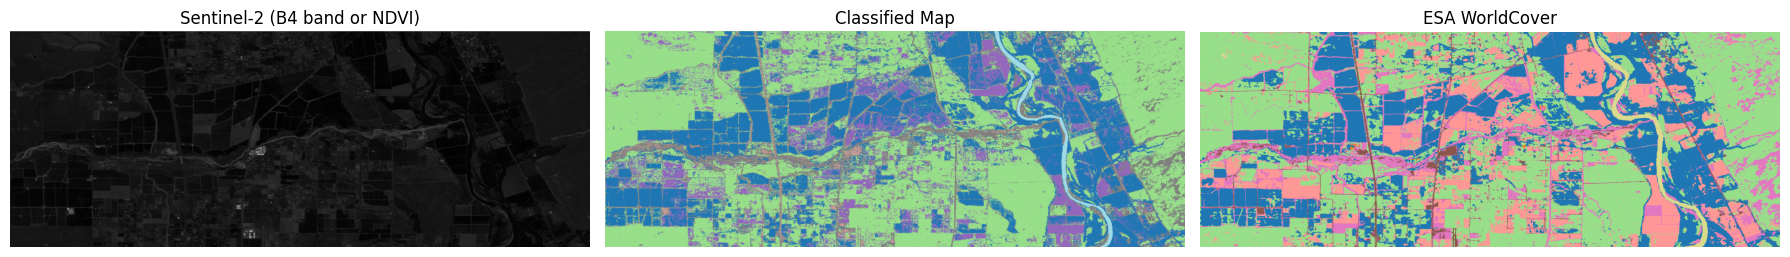

In [ ]:
import matplotlib.pyplot as plt
import rasterio
import numpy as np
def read_single_band(path):
    with rasterio.open(path) as src:
        data = src.read(1)  # read first band
    return data

# Read images
sentinel = read_single_band(sentinel_tif)  # choose a meaningful band, e.g. B4 (red) or NDVI band index if stored
classified = read_single_band(classified_tif)
esa = read_single_band(esa_tif)

# If sentinel is multi-band, you can read 3 bands and make a RGB composite:
# with rasterio.open(sentinel_tif) as src:
#     red = src.read(4)   # B4 band index (1-based)
#     green = src.read(3) # B3 band
#     blue = src.read(2)  # B2 band
# sentinel_rgb = np.dstack((red, green, blue))
# Normalize for display (optional)

# Plot side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Sentinel-2 (show one band or composite)
axs[0].imshow(sentinel, cmap='gray')
axs[0].set_title('Sentinel-2 (B4 band or NDVI)')
axs[0].axis('off')

# Classified map (with colormap for classes)
cmap_classes = plt.get_cmap('tab20')  # good categorical colormap
im = axs[1].imshow(classified, cmap=cmap_classes)
axs[1].set_title('Classified Map')
axs[1].axis('off')

# ESA WorldCover
cmap_esa = plt.get_cmap('tab20')
axs[2].imshow(esa, cmap=cmap_esa)
axs[2].set_title('ESA WorldCover')
axs[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
!pip install localtileserver